<a href="https://colab.research.google.com/github/LuLu1-1/Time-series-analysis/blob/main/time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


In [ ]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns 
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# moving average, smoothing, (two or three)exponential average

In [ ]:
ads = pd.read_csv('/content/sample_data/ads.csv', index_col=['Time'], parse_dates=['Time'])
cur = pd.read_csv('/content/sample_data/currency.csv', index_col=['Time'], parse_dates=['Time'])

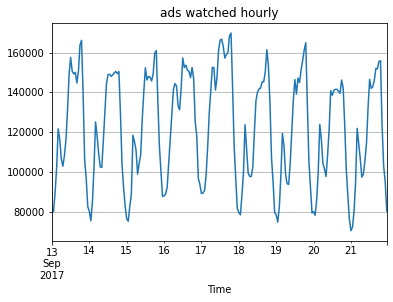

In [ ]:
ads.Ads.plot(grid=True,title='ads watched hourly')

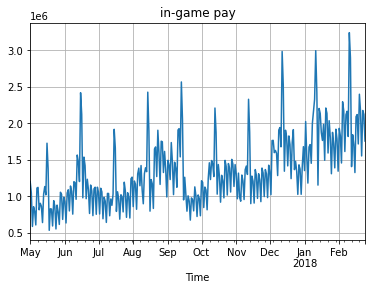

In [ ]:
cur.GEMS_GEMS_SPENT.plot(grid=True,title='in-game pay daily')

In [ ]:
# evaluate metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24)

116805.0

In [ ]:
def plotMovingAverage(series, window, scale=1.96, plot_intervals=False,  plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ko", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

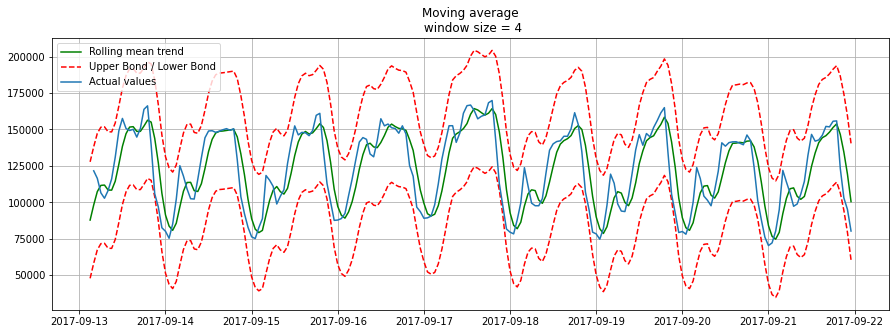

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True, plot_anomalies=True) 

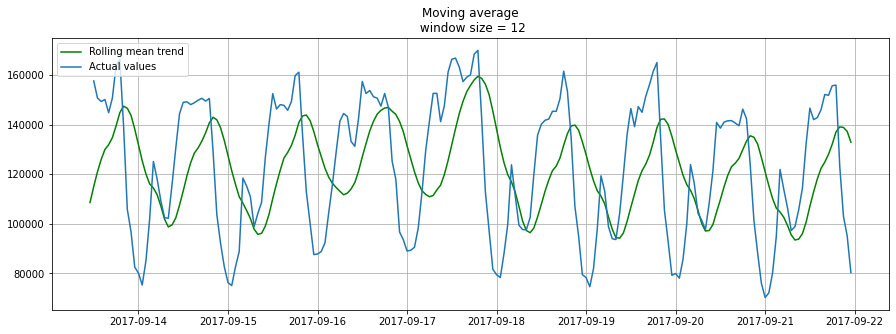

In [ ]:
plotMovingAverage(ads, 12) 

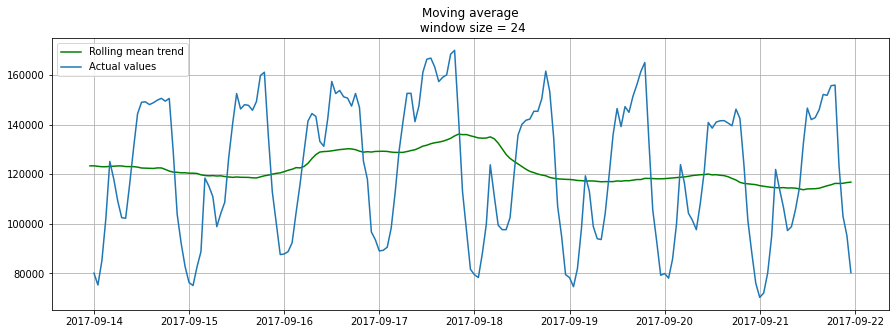

In [ ]:
plotMovingAverage(ads, 24)

In [ ]:
#make an anamoly
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

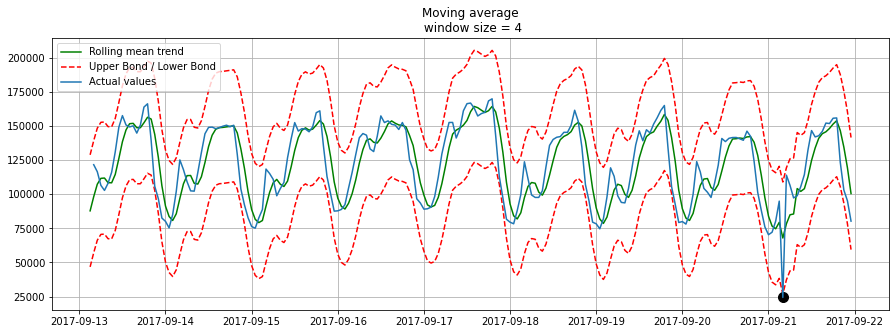

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

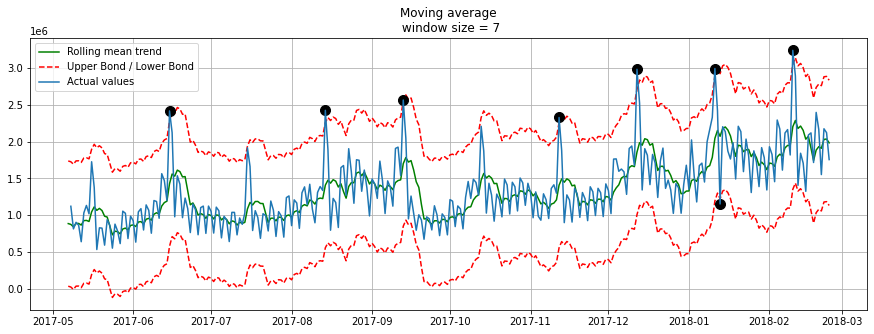

In [ ]:
plotMovingAverage(cur, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(ads, [0.6, 0.3, 0.1])

87025.5

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "g", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

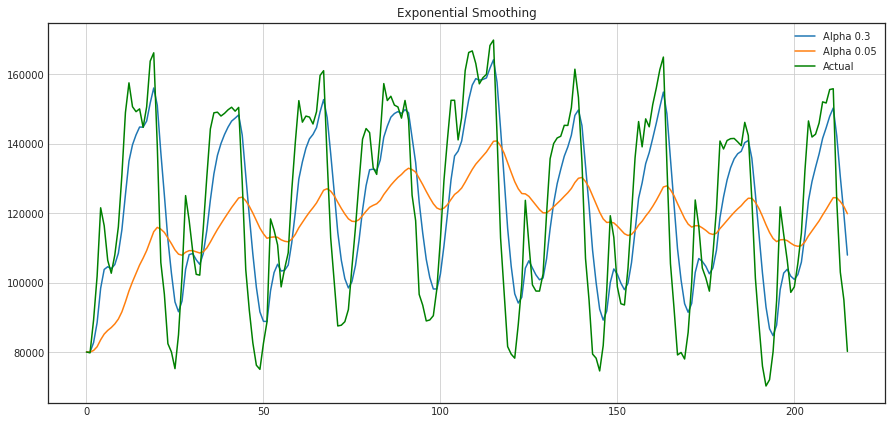

In [ ]:
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

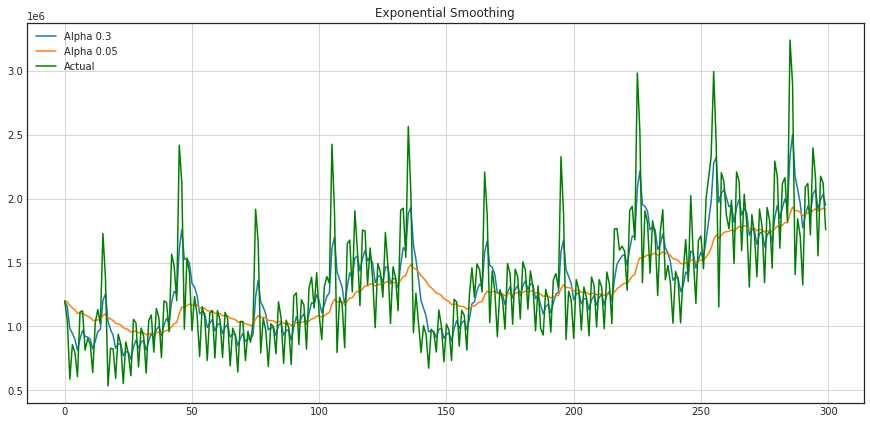

In [ ]:
plotExponentialSmoothing(cur.GEMS_GEMS_SPENT, [0.3, 0.05])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

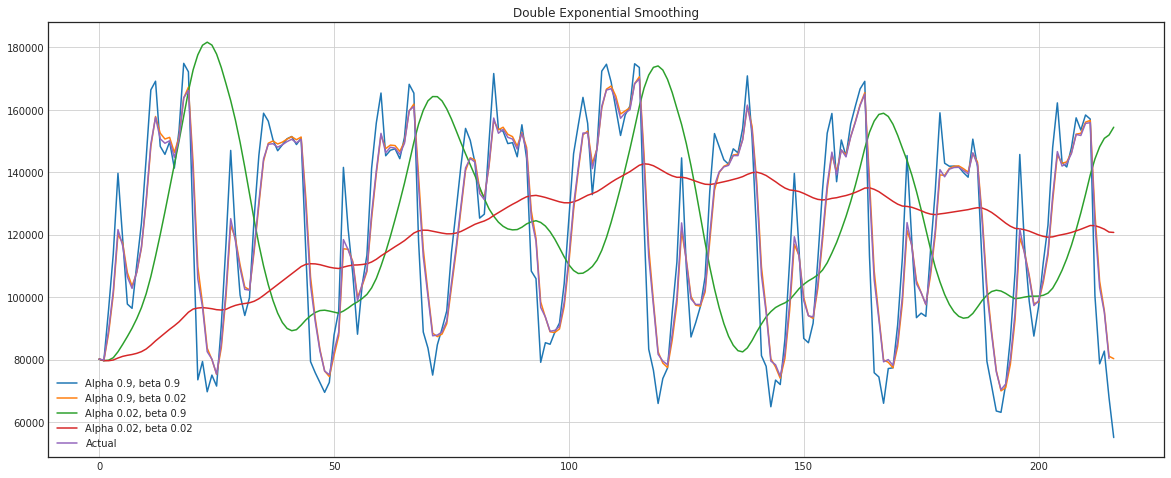

In [ ]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])

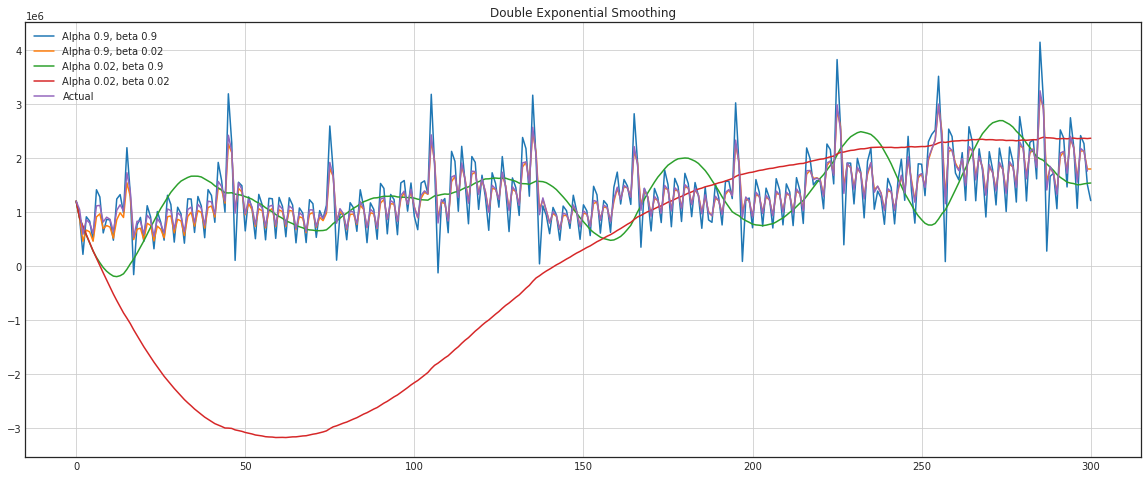

In [ ]:
plotDoubleExponentialSmoothing(cur.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11679441909042859 0.0026729736895769185 0.060091472931452894
CPU times: user 1.3 s, sys: 11 ms, total: 1.32 s
Wall time: 1.29 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(18, 8))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

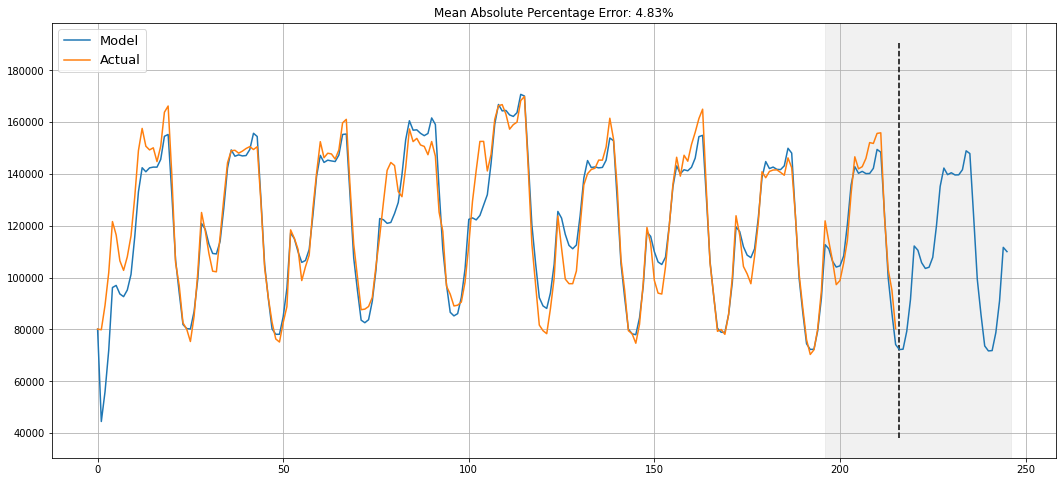

In [ ]:
plotHoltWinters(ads.Ads)

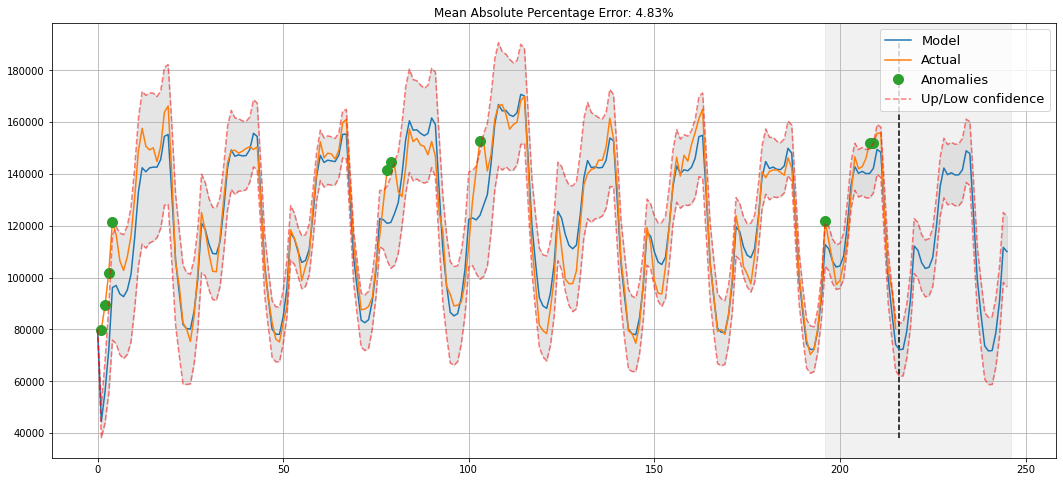

In [ ]:
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

# predict flight sales 

In [ ]:
# create time series
time=pd.Series(np.random.randn(20),index=pd.date_range('2016-01-01',periods=20))
time

2016-01-01    0.803552
2016-01-02    0.638820
2016-01-03    0.064351
2016-01-04   -0.506658
2016-01-05   -1.605923
2016-01-06   -0.695627
2016-01-07    0.203911
2016-01-08   -0.276340
2016-01-09   -0.832534
2016-01-10   -0.516615
2016-01-11    0.767962
2016-01-12    0.122851
2016-01-13    1.438397
2016-01-14    1.196851
2016-01-15   -1.119331
2016-01-16    0.141836
2016-01-17    1.670366
2016-01-18    1.097988
2016-01-19   -0.014601
2016-01-20   -0.357306
Freq: D, dtype: float64

In [ ]:
# time filtering
time.truncate(before='2016-1-10')
time.truncate(after='2016-1-10')

2016-01-01    0.803552
2016-01-02    0.638820
2016-01-03    0.064351
2016-01-04   -0.506658
2016-01-05   -1.605923
2016-01-06   -0.695627
2016-01-07    0.203911
2016-01-08   -0.276340
2016-01-09   -0.832534
2016-01-10   -0.516615
Freq: D, dtype: float64

In [ ]:
# resampling: up/ down
time.resample('M').sum()
a = time.resample('2D').sum()

a.resample('D').asfreq() # upsampling need interpolate
a.resample('D').ffill(1)# /.bfill(1)/.interpolate('linear')

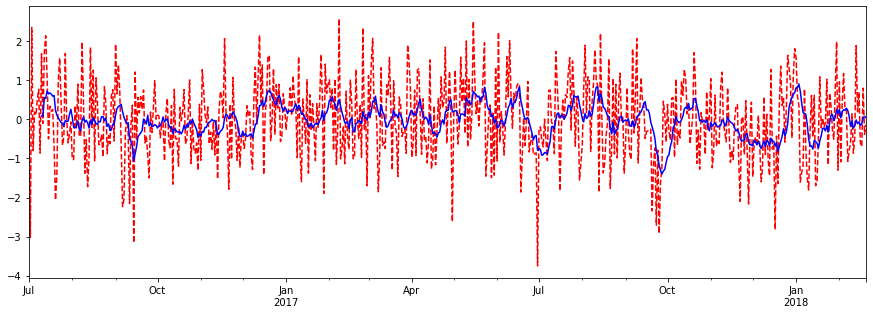

In [ ]:
# window sliding
df = pd.Series(np.random.randn(600), index = pd.date_range('7/1/2016', freq = 'D', periods = 600))
plt.figure(figsize=(15, 5))
df[:].plot(style='r--')
df[:].rolling(window=10).mean().plot(style='b')

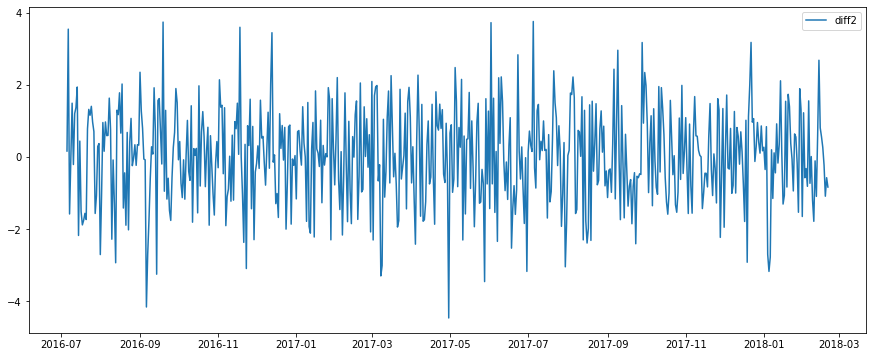

In [ ]:
x = df.index
plt.figure(figsize=(15,6))
#plt.plot(x,df,label = 'real')
#plt.plot(x,df.diff(1),label = 'diff1')
plt.plot(x,df.diff(2),label = 'diff2')
plt.legend()

In [ ]:
# ARMA(p，q) p: autocorrelation, q:moving average
# 平稳化处理后，若偏自相关函数是截尾的，而自相关函数是拖尾的，则建立AR模型；若偏自相关函数是拖尾的，而自相关函数是截尾的，则建立MA模型；若偏自相关函数和自相关函数均是拖尾的，则序列适合ARMA模型
# ARIMA(p,d,q) d: difference to stationary

In [ ]:
time = pd.read_csv('/content/gdrive/MyDrive/small dataset/passager.csv', index_col=[0])
time.index = pd.to_datetime(p.index)
p = time['Passengers']  
p = p.astype('float')
p.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: Passengers, dtype: float64

In [ ]:
p['1949-04':'1949-07']

Month
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
Name: Passengers, dtype: float64

examine stationary

In [ ]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
# moving average
def draw_trend(timeseries, size):
    plt.figure(figsize=(6,5))
    rol_mean = timeseries.rolling(window=size).mean()
    rol_std = timeseries.rolling(window=size).std()
    plt.plot(timeseries,color='blue', label='Original')
    plt.plot(rol_mean,color='red', label='Rolling Mean')
    plt.plot(rol_std,color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
 
#Dickey-Fuller test:
def teststationarity(ts,max_lag = None):
    dftest = statsmodels.tsa.stattools.adfuller(ts,maxlag= max_lag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

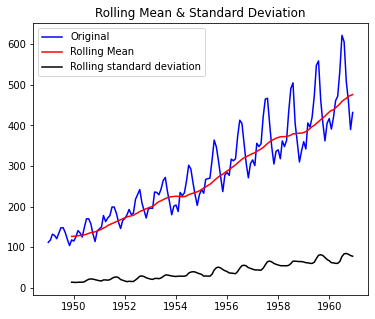

In [ ]:
draw_trend(p,12)

In [ ]:
teststationarity(p)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

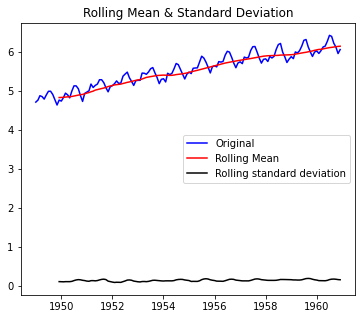

In [ ]:
draw_trend(np.log(p),12)

In [ ]:
def draw_moving(timeSeries, size):
    plt.figure(figsize=(6,5))
    # moving average
    rol_mean = timeSeries.rolling(window=size).mean()
    # exponential average
    #rol_weighted_mean = pd.Series.ewm(timeSeries, span=size)
    rol_weighted_mean=timeSeries.ewm(halflife=size).mean()
    plt.plot(timeSeries,color='blue', label='Original')
    plt.plot(rol_mean,color='red', label='Rolling Mean')
    plt.plot(rol_weighted_mean,color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

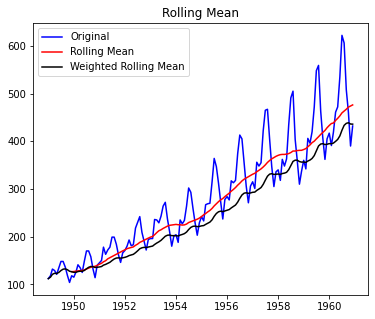

In [ ]:
draw_moving(p,12)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual

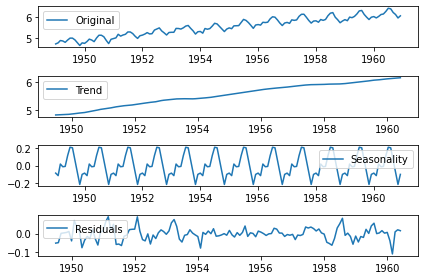

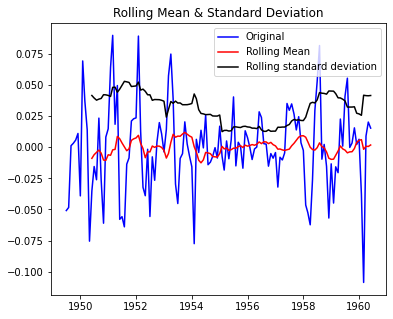

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

In [ ]:
trend , seasonal, residual = decompose(np.log(p))
residual.dropna(inplace=True)
draw_trend(residual,12)
teststationarity(residual)

In [ ]:
rol_mean = np.log(p).rolling(window=12).mean()
rol_mean.dropna(inplace=True)
p_diff = rol_mean.diff()
p_diff.dropna(inplace=True)
teststationarity(p_diff)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [ ]:
p_diff = p_diff.diff()
p_diff.dropna(inplace=True)
teststationarity(p_diff)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

In [ ]:
def draw_acf_pacf(ts,lags):
    f = plt.figure(figsize=(16,4))
    ax1 = f.add_subplot(131)
    plt.plot(ts,color='r')
    plt.title('Original')
    ax2 = f.add_subplot(132)
    plot_acf(ts,ax=ax2,lags=lags)
    ax3 = f.add_subplot(133)
    plot_pacf(ts,ax=ax3,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

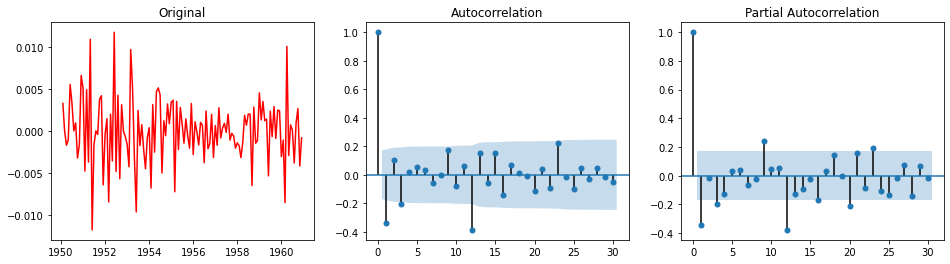

In [ ]:
# determine p,q,d
draw_acf_pacf(p_diff,30)

In [ ]:
model = ARIMA(p_diff, order=(1,1,1)) 
result_arima = model.fit( disp=-1, method='css')
predict_data=result_arima.predict(15,150)               
forecast=result_arima.forecast(21)                    

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


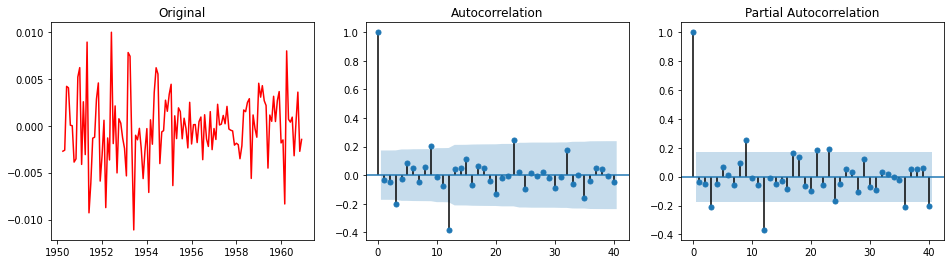

In [ ]:
draw_acf_pacf(result_arima.resid,40)

In [ ]:
sm.stats.durbin_watson(result_arima.resid)

2.0597473603608947

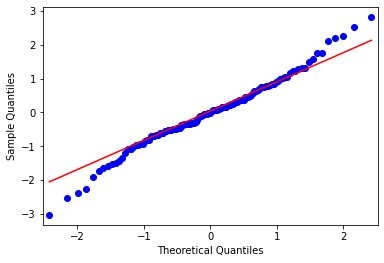

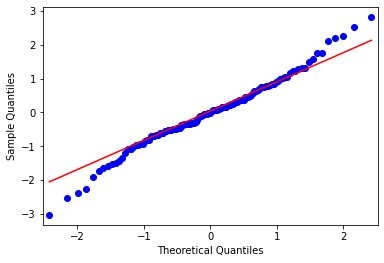

In [ ]:
from statsmodels.graphics.api import qqplot
qqplot(result_arima.resid, line='q',  fit=True)

In [ ]:
predict_ts = result_arima.predict()
diff_shift_ts = p_diff.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
rol_sum = np.log(p).rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

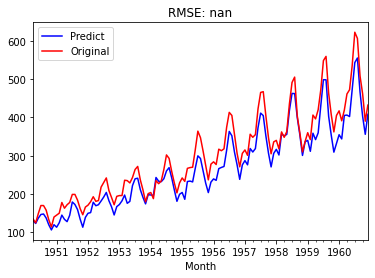

In [ ]:
ts_ = p[log_recover.index]  
log_recover.plot(color='blue', label='Predict')
ts_.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-p[14:])**2)/p.size))
plt.show()

In [ ]:
def confirm_p_q(data):
    fig = plt.figure(figsize=(8,6))
    train = teststeady(data)
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_pacf(train, lags=10, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_acf(train, lags=10, ax=ax2)
    plt.show()  
    pmax = int(len(data) / 10)
    qmax = int(len(data) / 10)
    AIC = sm.tsa.arma_order_select_ic(train,max_ar=pmax,max_ma=qmax,ic='aic')['aic_min_order']
    BIC = sm.tsa.arma_order_select_ic(train,max_ar=pmax,max_ma=qmax,ic='bic')['bic_min_order']
    HQIC = sm.tsa.arma_order_select_ic(train,max_ar=pmax,max_ma=qmax,ic='hqic')['hqic_min_order']
    print('AIC：',AIC)
    print('BIC：',BIC)
    print('HQIC：',HQIC)
    return AIC

def prediction(data,orders):
    ##tempmodel = ARMA(teststeady(data),pq).fit(disp=-1)
    tempmodel = sm.tsa.arima.ARIMA(data, order=orders).fit()
    print(tempmodel.summary())
    #num = 10
    #predictoutside1 = tempmodel.forecast(num)[0]#预测样本外的
    predictoutside2 = tempmodel.predict(len(tempmodel.predict()),len(tempmodel.predict()) + 9,dynamic=True)##也是样本外预测，预测结果一致
    predictinside = tempmodel.predict()##样本内预测
    init_value = yv[0]

    fig = plt.figure(figsize=(8, 6))
    predictinside = predictinside.cumsum()##差分还原
    pretrueinside = init_value + predictinside
    startprevalue = list(pretrueinside)[-1]
    predictoutside2 = predictoutside2.cumsum()##差分还原
    pretrueoutside = startprevalue + predictoutside2
    
    ##作图
    plt.plot(yv,label='原始值')
    plt.plot([init_value] + list(pretrueinside),label='样本内预测值')
    X = [i for i in range(len(yv)-11,len(yv))]
    plt.plot(X,[startprevalue] + list(pretrueoutside), label='样本外预测值')
    allpredata = [init_value] + list(pretrueinside) + list(pretrueoutside)
    plt.legend()
    plt.show()
    return tempmodel,allpredata

def evaluate_model(model,apd):
    delta = model.fittedvalues - tsres
    score = 1 - delta.var() / tsres.var()
    print('R^2：', score)
    allmse = mean_squared_error(apd,yv)##所有预测值跟所有原始值的MSE
    print('ALLMSE:',allmse)
